# Tagging genes with ddlite: learning and labeling function iteration

## Introduction
In this example **ddlite** app, we'll build a gene tagger from scratch. Here's why we developed ddlite:

* To provide a lighter-weight interface to structured information extraction for new DeepDive users
* To help advanced DeepDive rapidly develop and prototype applications and labeling functions (LFs)
* To investigate DeepDive's data programming approach to building inference systems

This example is centered around the second item. Domain-specific tagging systems take months or years to develop. They use hand-crafted model circuitry and accurate, hand-labeled training data. We're going to try to build a pretty good one in a few minutes with none of those things. The generalized extraction and learning utilities provided by ddlite will allow us to turn a sampling of article abstracts and some basic domain knowledge into an automated tagging system. Specifically, we want an accurate tagger for genes in academic articles. We have comprehensive dictionaries of genes, but applying a simple matching rule might yield a lot of false positives. For example, "p53" might get tagged as a gene if it refers to a page number. Our goal is to use data programming to improve precision.

Here's the pipeline we'll follow:

1. Obtain and parse input data (relevant article abstracts from PubMed)
2. Extract candidates for tagging
3. Generate features
4. Create a test set
5. Write labeling functions
6. Learn the tagging model
7. Iterate on labeling functions

Parts 3 through 7 are covered in this notebook. It requires candidates extracted from `GeneTaggerExample_Extraction.ipynb`, which covers parts 1 and 2.

In [1]:
%load_ext autoreload
%autoreload 2

import cPickle
from ddlite import *

## Loading candidate extractions
First, we'll load in the pickled candidates that we created in the last notebook. We can construct an `Entities` object with the file.

In [2]:
E = Entities('gene_tag_example/gene_tag_saved_entities_v2.pkl')

## `CandidateModel` objects and feature generation
We'll then create an `CandidateModel` object for our extracted gene candidates. This lets us iterate with our model and labeling functions. Since `Entities` defines a feature generation method, features are automatically created when we initialize a `CandidateModel` object. These are generic features from the NLP markup and dependency tree in the neighborhood of the mention. Alternatively, you can define a custom feature set as a NumPy array or a Scipy sparse matrix.

In [3]:
CM = CandidateModel(E)
print "Extracted {} features for each of {} mentions".format(CM.num_feats(), CM.num_candidates())

Extracted 35966 features for each of 1518 mentions


## Building a ground truth set with MindTagger
In order to evaluate our labeling functions and learning results, we'll create a small set of ground truth labels for some candidates using [Mindtagger](http://deepdive.stanford.edu/labeling). This will highlight each candidate in the sentence in which it appears. We set the response to yes if it is a mention of gene, and no otherwise. If you aren't sure, you can abstain from labeling. In a real application, we would likely want to tag more than 20 candidates.

In [4]:
CM.open_mindtagger(num_sample=20, width='100%', height=1200)

Making sure MindTagger is installed. Hang on!


Now, we'll retrieve the tags and add them to our `CandidateModel`. We'll then set our holdout set for training to be all of the examples for which we have a ground truth label.

In [5]:
CM.add_mindtagger_tags()
CM.set_holdout()

## Writing labeling functions
We'll use data programming to learn a logistic regression model which will predict the probability of a candidate entity being a true gene mention. Since our training data is not manually labeled, we'll generate many (potentially noisy) labels as a surrogate for precise, manual labels. Feature extraction and model learning are very simple in ddlite. Writing labeling functions is where the real artistry comes in. One of ddlite's goals is to enable rapid prototyping, debugging, and experimenting with labeling functions. These can be used either to create a simple standalone app, or to plug into DeepDive. Labeling functions, or LFs, are functions that take an `Candidate` object. They must return 1 (for a positive label), 0 (for abstaining), or -1 (for a negative example). For now, we'll write a few simple LFs to get started:

* The first, second, and third LFs return a positive label if the lemma "gene", "mutant", or "express" appear in a window around the mention, respectively
* The third LF returns a positive label if the dependency parent of any of the words in the mention is "mutation", and abstains otherwise
* The fourth, fifth, and sixth LF return a negative label if the mention candidate contains "DNA", "RNA", or "SNP" respectively (these are common uppercase nouns which are not genes) 

In [6]:
def post_window(m, key, n=3):
    s = list(m.idxs)
    b = len(m.lemmas) - np.max(s)
    s.extend([np.max(s) + i for i in range(1, min(b,n+1))])
    return key in [m.lemmas[i] for i in s]
def pre_window(m, key, n=3):
    s = list(m.idxs)
    b = np.min(s)
    s.extend([b - i for i in range(1, min(b,n+1))])
    return key in [m.lemmas[i] for i in s]
def stopper(m, stop):
    return stop in [m.lemmas[i] for i in m.idxs]

def LF_gene(m):
    return 1 if (post_window(m, 'gene') or pre_window(m, 'gene')) else 0
def LF_mutant(m):
    return 1 if (post_window(m, 'mutant') or pre_window(m, 'mutant')) else 0
def LF_express(m):
    return 1 if (post_window(m, 'express') or pre_window(m, 'express')) else 0
def LF_mutation(m):
    return 1 if 'mutation' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_dna(m):
    return -1 if stopper(m, 'dna') else 0
def LF_rna(m):
    return -1 if stopper(m, 'rna') else 0
def LF_snp(m):
    return -1 if stopper(m, 'snp') else 0

Our intuition is that the few simple LFs given above won't yield a good model. We'll see this more concretely when we evaluate the labeling functions. For now, let's leave them as is. After writing the LFs, we simply collect them and apply them to mentions. If we define more LFs later, we can apply them incrementally or overwrite all the LFs so far.

In [13]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,6)

LFs = [LF_gene, LF_mutant, LF_express, LF_mutation, LF_dna, LF_rna, LF_snp]
CM.apply_LFs(LFs, clear=True)

We'll use ddlite's LF assessment utilities to debug and analyze our LFs before running inference. First, we'll generate summary plots which show the following:

* Do the LFs cover the data well or do we have many candidates for which all of the LFs abstained?
* Is the overlap between the LFs? Do many return positive or negative labels for the same candidate?
* Do the LFs conflict with each other? Do candidates tend to have many of one type of label, or a mix?

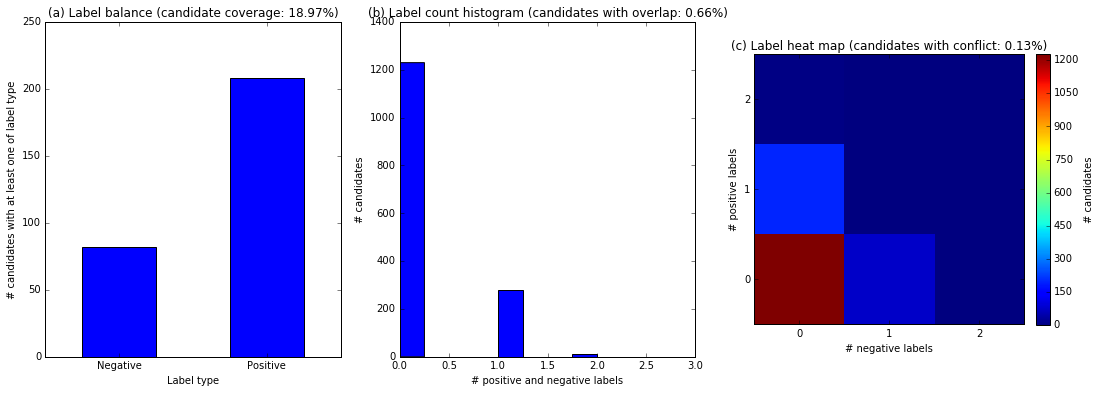

In [14]:
CM.plot_LF_stats()

As we may expect, the few LFs do not cover the data well. Most candidates have no positive or negative labels, as seen in all plots. We also have almost no conflict between LFs. We can switch to an LF view of these measures and show tables for the LFs with the most conflict, lowest coverage, and lowest empirical accuracy as compared to the MindTagger labels.

In [15]:
CM.top_conflict_LFs(n=3)

Labeling function,Fraction of candidates where LF has conflict
LF_gene,0.001
LF_dna,0.001
LF_snp,0.000


In [16]:
CM.lowest_coverage_LFs(n=3)

Labeling function,Fraction of abstained votes
LF_express,0.993
LF_rna,0.989
LF_mutant,0.984


In [17]:
CM.lowest_empirical_accuracy_LFs(n=10)

Labeling function,Empirical LF accuracy
LF_snp,0.000 (n=0)
LF_express,0.000 (n=0)
LF_mutant,0.000 (n=0)
LF_gene,1.000 (n=1)
LF_rna,1.000 (n=1)
LF_dna,1.000 (n=2)
LF_mutation,1.000 (n=1)


For a small test set and low coverage LFs, we may see that we can't assess accuracy since the MindTagger labels and LF positive and negative labels don't overlap. If we observe LFs with very low accuracy and a sufficiently large sample size, this could be an indication that the LF is buggy.

## Learning
To learn weights for the features and LFs, we use a simple, regularized logistic regression model. Again, the results won't be meaningful without more LFs. We'll tell ddlite to log the results and print out a summary table

In [18]:
%time CM.learn_weights(nSteps=500, sample=False, mu=1e-6, use_sparse=True, verbose=True, log=True)


Learning epoch =  0	100	200	300	400	CPU times: user 2.25 s, sys: 12 ms, total: 2.26 s
Wall time: 2.33 s


<ddlite.ModelLog instance at 0x7f5620882cf8>

We can use [DeepDive-style calibration plots](http://deepdive.stanford.edu/calibration) to evaluate the quality of our predictions. We aren't using a holdout set right now, so let's just look at the histogram of probabilities.

/home/henryre/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/henryre/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


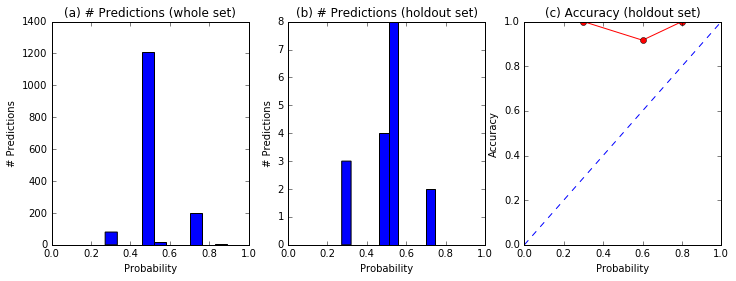

In [19]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,4)

CM.plot_calibration()

## Iterating with labeling functions
After analyzing our LFs and obtaining model results, we can revise our LF set. We can see all of the results thus far, and reopen MindTagger to see what types of mentions are predicted incorrectly.

In [20]:
CM.show_log()

ID,# LFs,# ground truth,Precision,Recall,F1
0,7,17,0.929,1.000,0.963


In [ ]:
CM.open_mindtagger(width='100%', height=1200)